In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic cybersecurity dataset
n_samples = 1000
data = {
    'packet_size': np.random.normal(loc=500, scale=100, size=n_samples),
    'source_ip': np.random.choice(['192.168.1.1', '192.168.1.2', '192.168.1.3'], n_samples),
    'destination_ip': np.random.choice(['10.0.0.1', '10.0.0.2', '10.0.0.3'], n_samples),
    'protocol': np.random.choice(['TCP', 'UDP', 'ICMP'], n_samples),
    'attack_type': np.random.choice(['benign', 'DDoS', 'phishing', 'malware'], n_samples)
}

df = pd.DataFrame(data)

# Introduce missing values (MAR and MCAR)
mask = np.random.rand(n_samples) < 0.1
df.loc[mask, 'packet_size'] = np.nan  # MCAR
df.loc[mask, 'attack_type'] = np.nan  # MAR (correlating missing with 'packet_size')

# Display the first few rows of the dataset
print("Sample data")
print(df.head())


Sample data
   packet_size    source_ip destination_ip protocol attack_type
0   549.671415  192.168.1.3       10.0.0.1      UDP        DDoS
1   486.173570  192.168.1.1       10.0.0.2      TCP      benign
2   564.768854  192.168.1.3       10.0.0.2      TCP      benign
3   652.302986  192.168.1.1       10.0.0.2     ICMP        DDoS
4   476.584663  192.168.1.3       10.0.0.1     ICMP    phishing


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   packet_size     895 non-null    float64
 1   source_ip       1000 non-null   object 
 2   destination_ip  1000 non-null   object 
 3   protocol        1000 non-null   object 
 4   attack_type     895 non-null    object 
dtypes: float64(1), object(4)
memory usage: 39.2+ KB


In [ ]:
df.describe()

,packet_size
count,895.000000
mean,501.989539
std,98.219780
min,175.873266
25%,435.857013
50%,502.609105
75%,564.543007
max,885.273149


In [ ]:
df.shape

(1000, 5)

In [ ]:
pip install MissForest

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from missforest import MissForest
from sklearn.impute import KNNImputer

# Prepare the data for imputation by encoding categorical features
df_encoded = df.copy()
df_encoded['source_ip'] = df_encoded['source_ip'].astype('category').cat.codes
df_encoded['destination_ip'] = df_encoded['destination_ip'].astype('category').cat.codes
df_encoded['protocol'] = df_encoded['protocol'].astype('category').cat.codes
df_encoded['attack_type'] = df_encoded['attack_type'].astype('category').cat.codes

# Perform Multiple Imputation by Chained Equations (MICE)
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
df_mice = pd.DataFrame(mice_imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Perform MissForest Imputation
missforest_imputer = MissForest()
df_missforest = pd.DataFrame(missforest_imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Perform K-Nearest Neighbors (KNN) Imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Convert back the encoded categorical columns to original categories
def decode(df, df_imputed):
    df_imputed['source_ip'] = df['source_ip'].astype('category').cat.categories[df_imputed['source_ip'].astype(int)]
    df_imputed['destination_ip'] = df['destination_ip'].astype('category').cat.categories[df_imputed['destination_ip'].astype(int)]
    df_imputed['protocol'] = df['protocol'].astype('category').cat.categories[df_imputed['protocol'].astype(int)]
    df_imputed['attack_type'] = df['attack_type'].astype('category').cat.categories[df_imputed['attack_type'].astype(int)]
    return df_imputed

df_mice = decode(df, df_mice)
df_missforest = decode(df, df_missforest)
df_knn = decode(df, df_knn)

print("\nImputed Data with MICE:")
print(df_mice.head())

print("\nImputed Data with MissForest:")
print(df_missforest.head())

print("\nImputed Data with KNN:")
print(df_knn.head())


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


Imputed Data with MICE:
   packet_size    source_ip destination_ip protocol attack_type
0   549.671415  192.168.1.3       10.0.0.1      UDP        DDoS
1   486.173570  192.168.1.1       10.0.0.2      TCP      benign
2   564.768854  192.168.1.3       10.0.0.2      TCP      benign
3   652.302986  192.168.1.1       10.0.0.2     ICMP        DDoS
4   476.584663  192.168.1.3       10.0.0.1     ICMP    phishing

Imputed Data with MissForest:
   packet_size    source_ip destination_ip protocol attack_type
0   549.671415  192.168.1.3       10.0.0.1      UDP        DDoS
1   486.173570  192.168.1.1       10.0.0.2      TCP      benign
2   564.768854  192.168.1.3       10.0.0.2      TCP      benign
3   652.302986  192.168.1.1       10.0.0.2     ICMP        DDoS
4   476.584663  192.168.1.3       10.0.0.1     ICMP    phishing

Imputed Data with KNN:
   packet_size    source_ip destination_ip protocol attack_type
0   549.671415  192.168.1.3       10.0.0.1      UDP        DDoS
1   486.173570  192.168.

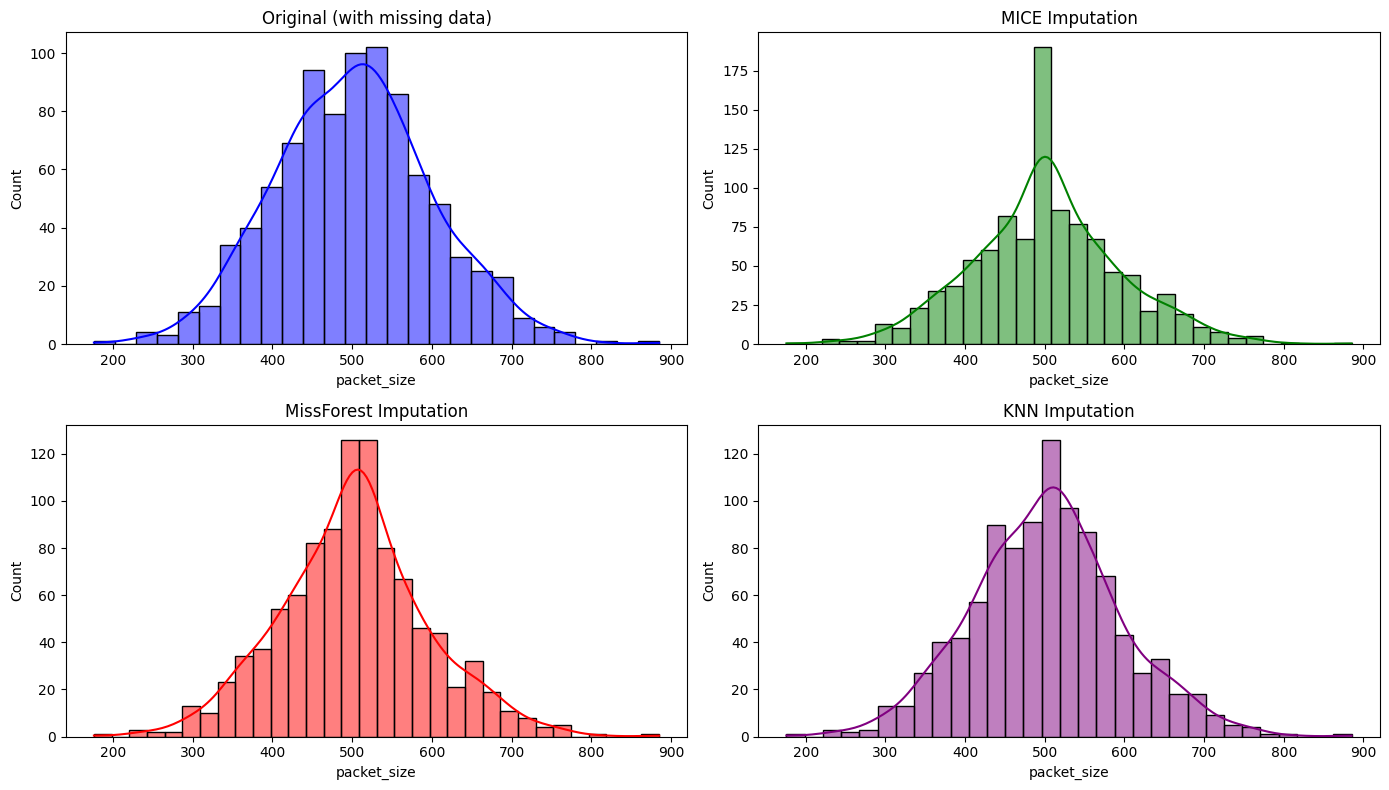

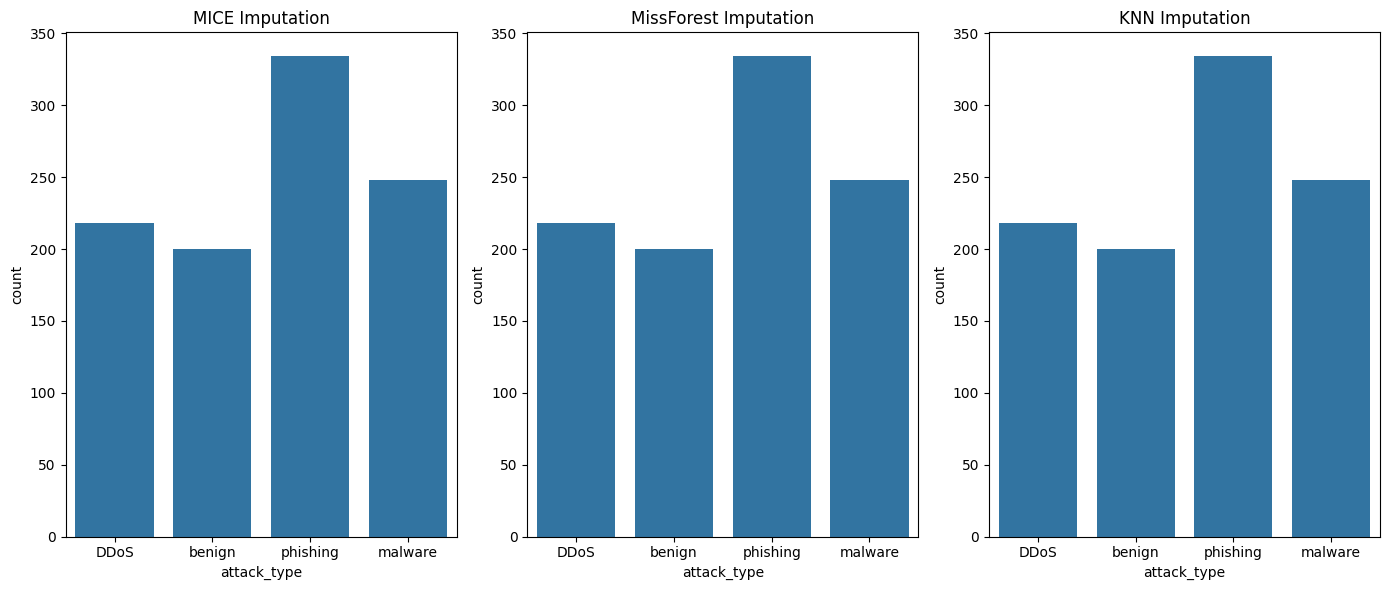

In [ ]:
# Visualizing the distribution of 'packet_size' before and after imputation
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.histplot(df['packet_size'].dropna(), kde=True, color='blue')
plt.title('Original (with missing data)')

plt.subplot(2, 2, 2)
sns.histplot(df_mice['packet_size'], kde=True, color='green')
plt.title('MICE Imputation')

plt.subplot(2, 2, 3)
sns.histplot(df_missforest['packet_size'], kde=True, color='red')
plt.title('MissForest Imputation')

plt.subplot(2, 2, 4)
sns.histplot(df_knn['packet_size'], kde=True, color='purple')
plt.title('KNN Imputation')

plt.tight_layout()
plt.show()

# Visualizing the integrity of the 'attack_type' feature after imputation
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='attack_type', data=df_mice)
plt.title('MICE Imputation')

plt.subplot(1, 3, 2)
sns.countplot(x='attack_type', data=df_missforest)
plt.title('MissForest Imputation')

plt.subplot(1, 3, 3)
sns.countplot(x='attack_type', data=df_knn)
plt.title('KNN Imputation')

plt.tight_layout()
plt.show()
